In [90]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines
from imageio import imread

%matplotlib inline

from math import cos, asin, sqrt

In [3]:
crime_all = pd.read_csv('crime_all.csv')
cctv_2014 = pd.read_csv('CCTV_2014.csv')
cctv_2019 = pd.read_csv('CCTV_2019.csv')

In [4]:
crime_all['CrimeDateAndTime'] = crime_all['CrimeDate'] + ' ' + crime_all['CrimeTime']
crime_all['CrimeDateAndTime'] = pd.to_datetime(crime_all['CrimeDateAndTime'])

In [5]:
# Index to filter by between_time
crime_all.index = crime_all['CrimeDateAndTime']

In [6]:
def filterByYear(year):
    start_date = '04/01/{}'.format(year)
    end_date = '04/01/{}'.format(year + 1)

    mask_date = (crime_all['CrimeDateAndTime'] > start_date) & (crime_all['CrimeDateAndTime'] <= end_date)
    return crime_all.loc[mask_date]

In [7]:
def filterByTime(crime, startTime, endTime):
    return crime.between_time(startTime, endTime)

In [8]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

In [9]:
def getLocations(crimes, cctvs):
    crime_locations = []
    cctv_locations = []

    for index, crime in crimes.iterrows():
        lon, lat = crime["Longitude"], crime["Latitude"]
        crime_locations.append([lon, lat])

    for index, cctv in cctvs.iterrows():
        now = cctv["Location 1"]
        c_lat, c_lon = tuple(map(float, now[1:-1].split(',')))
        cctv_locations.append([c_lon, c_lat])
        
    return crime_locations, cctv_locations

In [10]:
# calculates number of crimes with at least one CCTV in `max_range`km
def calculateF(crime_locations, cctv_locations, max_range):
    value = 0
    for [lon, lat] in crime_locations:
        for [c_lon, c_lat] in cctv_locations:
            if distance(lat, lon, c_lat, c_lon) <= max_range:
                value += 1
                break
    return value

In [11]:
# calculates number of crimes with no CCTV in `max_range`km
def calculateFarthest(crime_locations, cctv_locations, max_range):
    value = 0
    for [lon, lat] in crime_locations:
        flag = True
        for [c_lon, c_lat] in cctv_locations:
            if distance(lat, lon, c_lat, c_lon) <= max_range:
                flag = False
                break
        if flag == True:
            value += 1
    return value

In [12]:
crime_2014 = filterByYear(2014)
crime_2019 = filterByYear(2018)

In [13]:
crime_2014_locations, cctv_2014_locations = getLocations(crime_2014, cctv_2014)

## Calculate

In [14]:
def calculateG(crimes, cctvs, max_range):
    crime_locations, cctv_locations = getLocations(crimes, cctvs)
    return calculateF(crime_locations, cctv_locations, max_range)

In [15]:
def calculateE(crimes, cctvs, max_range):
    crime_locations, cctv_locations = getLocations(crimes, cctvs)
    return calculateFarthest(crime_locations, cctv_locations, max_range)

In [16]:
crime_2014_day = filterByTime(crime_2014, '9:00', '19:00')

In [17]:
crime_2014_night = filterByTime(crime_2014, '19:01', '8:59')

In [20]:
print('2014, day:', calculateG(crime_2014_day, cctv_2014, 0.01))
print('2014, night:', calculateG(crime_2014_night, cctv_2014, 0.01))

2014, day: 232
2014, night: 176


In [40]:
print('2014, day – camera range:', calculateG(crime_2014_day, cctv_2014, 0.075))
print('2014, night – camera range:', calculateG(crime_2014_night, cctv_2014, 0.075))

2014, day – camera range: 3223
2014, night – camera range: 2797


In [18]:
crime_2019_day = filterByTime(crime_2019, '9:00', '19:00')
crime_2019_night = filterByTime(crime_2019, '19:01', '8:59')

In [33]:
print('2019, day:', calculateG(crime_2019_day, cctv_2019, 0.01))
print('2019, night:', calculateG(crime_2019_night, cctv_2019, 0.01))

2019, day: 328
2019, night: 328


In [39]:
print('2019, day – camera range:', calculateG(crime_2019_day, cctv_2019, 0.075))
print('2019, night – camera range:', calculateG(crime_2019_night, cctv_2019, 0.075))

2019, day – camera range: 4011
2019, night – camera range: 3911


In [37]:
print('2014, day – far:', calculateE(crime_2014_day, cctv_2014, 0.1))
print('2014, night – far:', calculateE(crime_2014_night, cctv_2014, 0.1))

2014, day – far: 18951
2014, night – far: 17651


In [38]:
print('2019, day – far:', calculateE(crime_2019_day, cctv_2019, 0.1))
print('2019, night – far:', calculateE(crime_2019_night, cctv_2019, 0.1))

2019, day – far: 19083
2019, night – far: 18837


## Visuals

In [146]:
def getMinRoutes(crimes, cctvs, range_dist):
    crime_locations, cctv_locations = getLocations(crimes, cctvs)
    
    routes = []
    
    for [lon, lat] in crime_locations:
        min_dist = 100000
        cur_lon, cur_lat = 0, 0
        for [c_lon, c_lat] in cctv_locations:
            cur_dist = distance(lat, lon, c_lat, c_lon)
            if cur_dist < min_dist:
                min_dist = cur_dist
                cur_lon, cur_lat = c_lon, c_lat
        if min_dist > range_dist:
            continue
        routes.append([lon, lat])
    return routes

def getMaxRoutes(crimes, cctvs, range_dist):
    crime_locations, cctv_locations = getLocations(crimes, cctvs)
    
    routes = []
    
    for [lon, lat] in crime_locations:
        max_dist = -100000
        cur_lon, cur_lat = 0, 0
        for [c_lon, c_lat] in cctv_locations:
            cur_dist = distance(lat, lon, c_lat, c_lon)
            if cur_dist > max_dist:
                max_dist = cur_dist
                cur_lon, cur_lat = c_lon, c_lat
        if max_dist <= range_dist:
            continue
        routes.append([lon, lat])
    return routes

In [137]:
routes_2014_day = getMinRoutes(crime_2014_day, cctv_2014, 0.075)

In [147]:
routes_2014_far = getMaxRoutes(crime_2014_day, cctv_2014, 0.075)

In [148]:
print(len(routes_2014_day))
print(len(routes_2014_far))

3223
23054


In [176]:
def drawMapFrom(routes_us, cctv_locations, file_name):
    plt.figure(figsize=(20,20))
    map = Basemap(
        projection='merc',
        llcrnrlon=-76.7078027,
        llcrnrlat=39.196187,
        urcrnrlon=-76.5318817,
        urcrnrlat=39.371978,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

    lats = [lat for [lon, lat] in cctv_locations]
    lons = [lon for [lon, lat] in cctv_locations]

    x, y = map(lons, lats)
    
    map.scatter(x, y, marker='+',color='r', zorder=2)
    
    lats = [lat for [lon, lat] in routes_us]
    lons = [lon for [lon, lat] in routes_us]

    x, y = map(lons, lats)
    
    map.scatter(x, y, marker='o',color='b', zorder=1)
    
    img = imread("contour.png")
    map.imshow(img, zorder=0, origin='upper')
    plt.savefig('{}.png'.format(file_name), format = "png", dpi = 600)
    plt.show()
    return 0

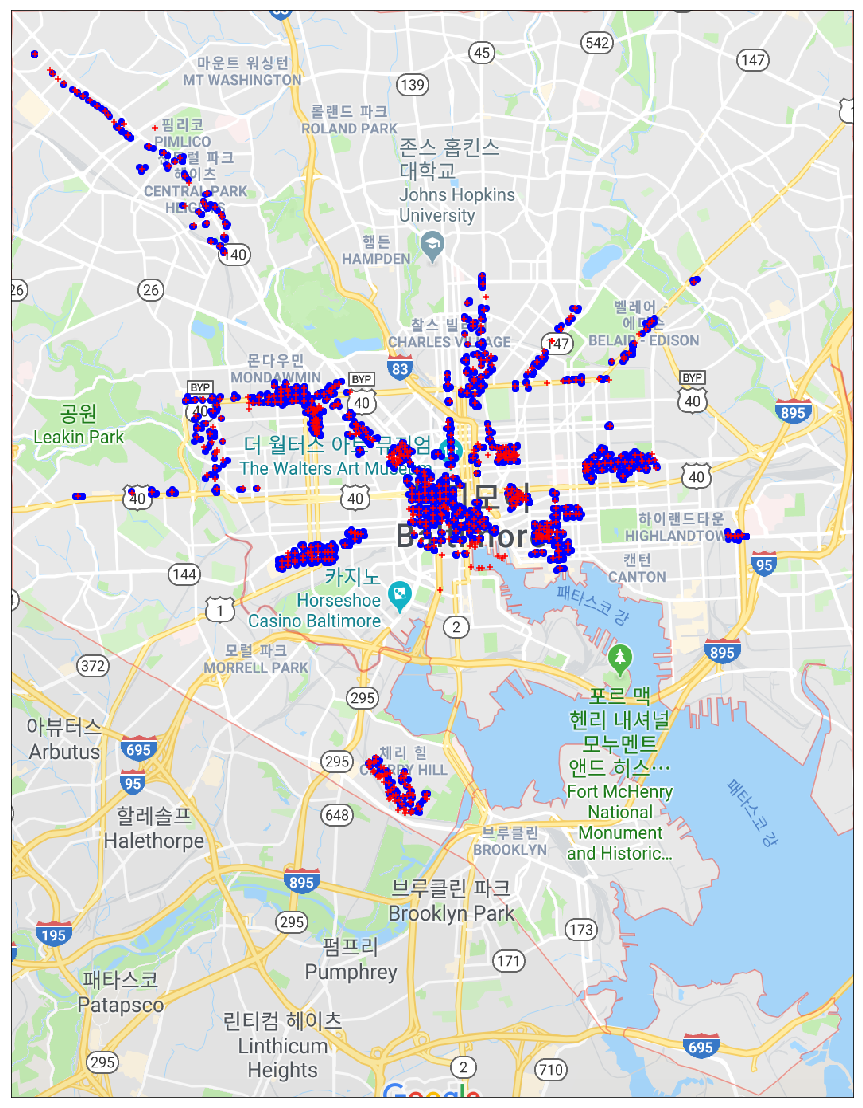

0

In [177]:
drawMapFrom(routes_2014_day, cctv_2014_locations, '2014_day_near')

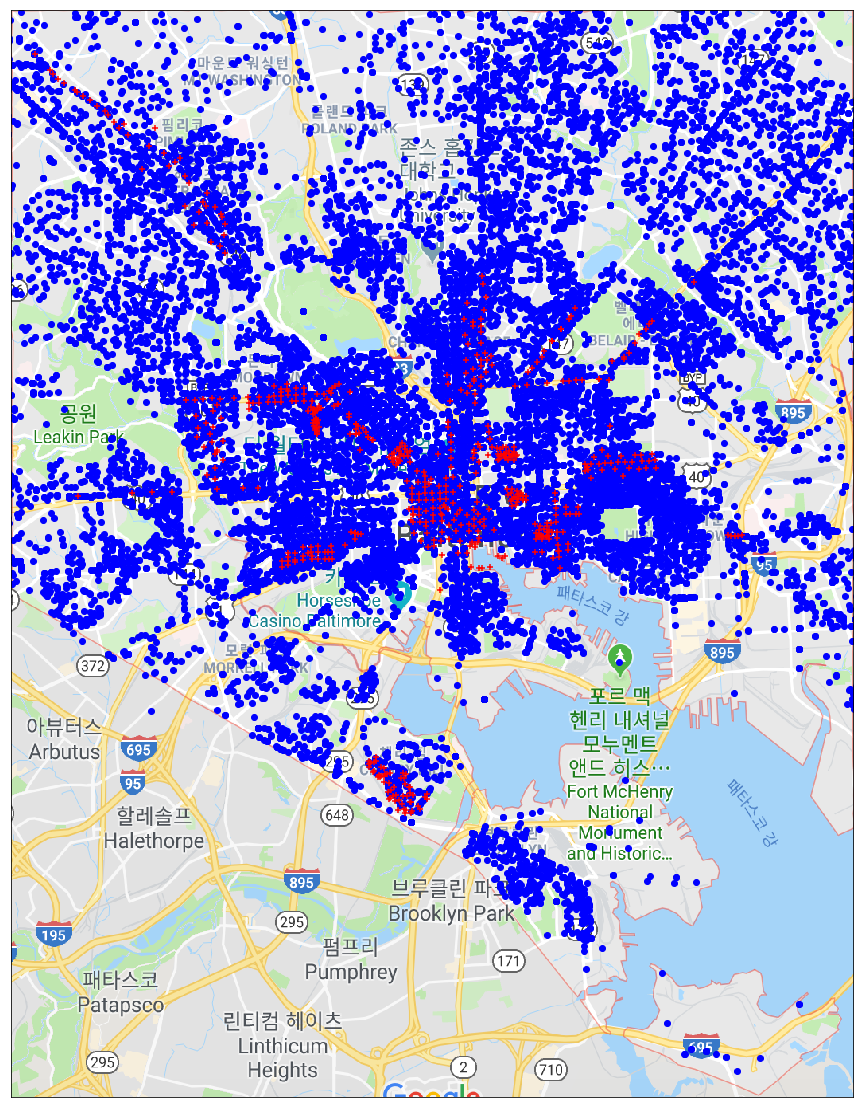

0

In [178]:
drawMapFrom(routes_2014_far, cctv_2014_locations, '2014_day_far')

In [151]:
print(cctv_2014.shape)
print(cctv_2019.shape)

(603, 4)
(720, 4)


In [154]:
print(crime_2014.shape)
print(crime_2019.shape)

(44603, 17)
(47837, 17)


In [158]:
print(44603/603, 47837/720)

73.96849087893864 66.44027777777778


In [159]:
crime_2019_locations, cctv_2019_locations = getLocations(crime_2019, cctv_2019)

In [161]:
routes_2019_day = getMinRoutes(crime_2019_day, cctv_2019, 0.075)

In [162]:
routes_2019_day_far = getMaxRoutes(crime_2019_day, cctv_2019, 0.075)

In [164]:
print(len(routes_2019_day))
print(len(routes_2019_day_far))

4011
23973


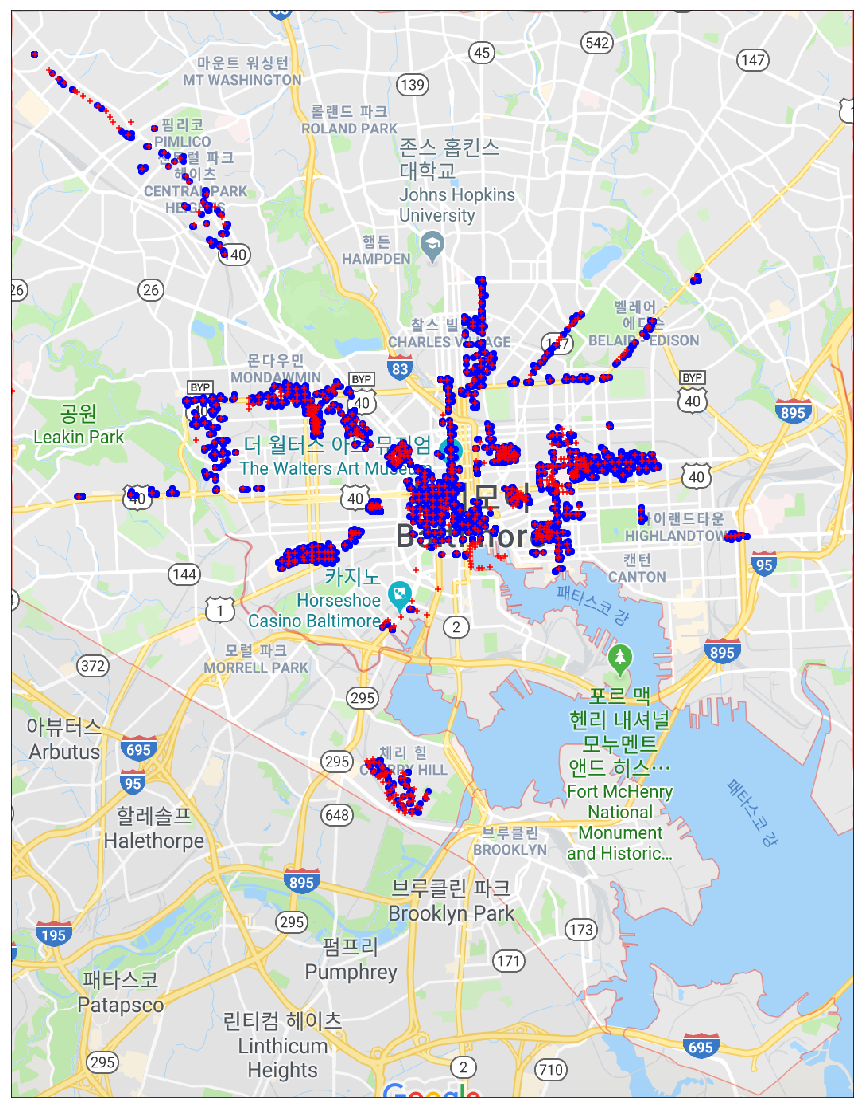

0

In [179]:
drawMapFrom(routes_2019_day, cctv_2019_locations, '2019_day_near')

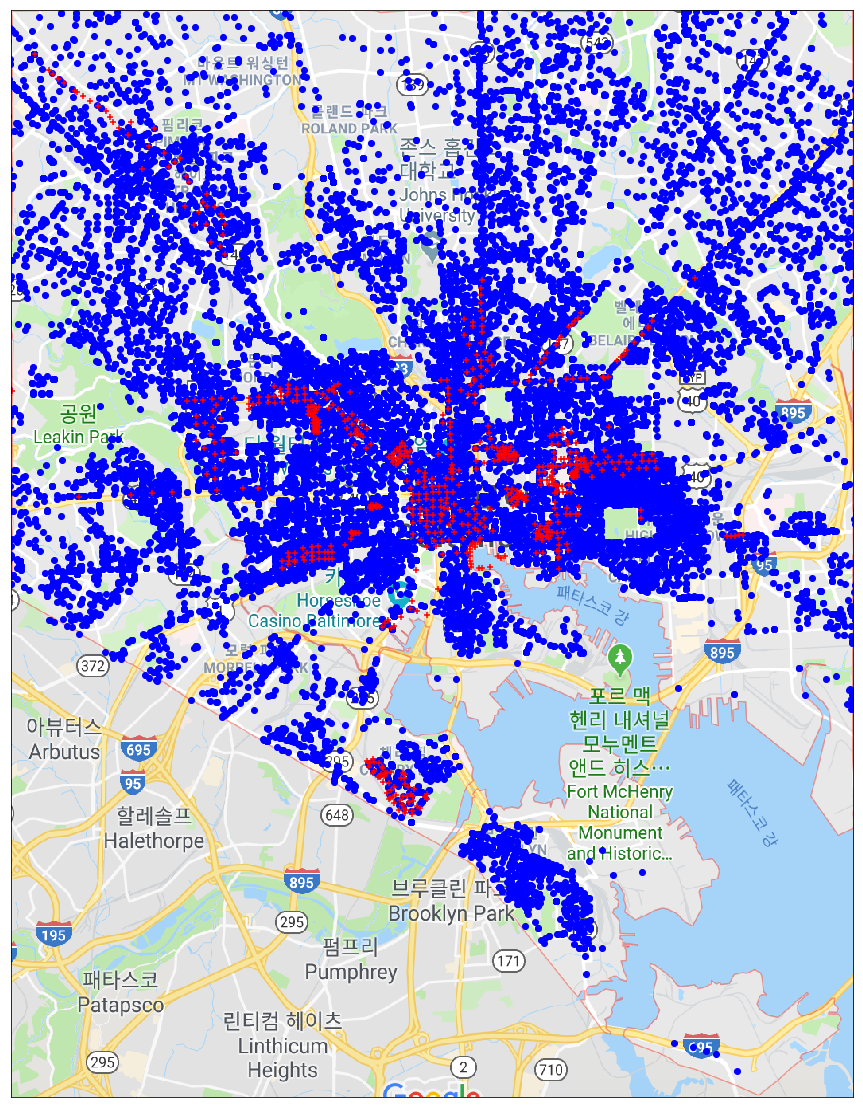

0

In [180]:
drawMapFrom(routes_2019_day_far, cctv_2019_locations, '2019_day_far')